# Churn Rate Prediction in Telecommunications: The Interconnect Case

The telecommunications operator Interconnect would like to forecast its customer churn rate. If a user is found to be planning to leave, they will be offered promotional codes and special plan options. Interconnect’s marketing team has collected some personal data from its customers, including information about their plans and contracts.

**Interconnect Services**

Interconnect primarily provides two types of services:

1. Landline communication. The phone can be connected to multiple lines simultaneously.
2. Internet. The network can be set up through a telephone line (DSL, Digital Subscriber Line) or via a fiber optic cable.

Some other services offered by the company include::

- Internet Security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*).
- A technical support line (*TechSupport*).
- Cloud file storage and data backup (*OnlineBackup*).
- TV Streaming (*StreamingTV*) and a movie directory (*StreamingMovies*).

Customers can choose between monthly payments or signing a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**Data Description**

The data consists of files obtained from different sources:

- `contract.csv` — Contract information;
- `personal.csv` — Customer personal data;
- `internet.csv` — Information about Internet services;
- `phone.csv` — Information about phone services.

In each file, the `customerID` column contains a unique code assigned to each customer. The contract information is valid as of February 1, 2020.

### Project Phases

Phase 1: Exploratory Analysis
- Check for duplicates, null values, and data types
- Initial visualizations

Phase 2: Engineering and Cleaning
- Variable conversion and imputation
- Creation of the 'Churn' column
- Review of class balance

Phase 3: Feature Selection
- Correlation analysis / use of Boruta, SHAP, or filtering methods
- Dimensionality reduction if applicable

Phase 4: Feature Engineering
- One-hot encoding, scaling, creation of new columns

Phase 5: Modeling
- Testing different binary classification algorithms
- Evaluation using metrics: F1, ROC AUC, precision, recall

Phase 6: Interpretation and Conclusion
- Model interpretation
- Recommendations for the marketing team


## Exploratory Analysis and Cleaning

Let's do a bit of exploratory data analysis to get familiar with the structure of the data and see what we’re going to be dealing with.

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

sns.set_style("whitegrid")
sns.despine()
sns.set_palette("dark")

<Figure size 640x480 with 0 Axes>

In [41]:
contract_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/contract.csv')
personal_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/personal.csv')
internet_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/internet.csv')
phone_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/phone.csv')

### Contract Data

In [42]:
contract_data.info()
contract_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [43]:
# Converting the type of data to datetime.

contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])

# Using format = %Y-%m-%d %H:%M:%S kept turning the whole column into NaT. We're replacing "No" with NaT first, then turning into datetime.

contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'].replace('No', pd.NaT),  errors='coerce')

contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [86]:
# Theres 'TotalCharges' with ' '. Why could that be?

print('Contracts with no total charges:\n\n',contract_data[contract_data['TotalCharges'] == ' '][['customerID','BeginDate']])
print('\nMost recent date in the dataframe:',sorted(contract_data['BeginDate'].unique())[-1])

Contracts with no total charges:

 Empty DataFrame
Columns: [customerID, BeginDate]
Index: []

Most recent date in the dataframe: 2020-02-01 00:00:00


All contracts with no total charges on them have begin dates of 2020-02-01, which coincidentally is the latest date on the dataset. That's probably because these users haven't been charged yet and their contracts are new.

In [45]:
# We're converting the column to a number and filling out nulls with 0.

contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'],errors='coerce')

contract_data['TotalCharges'] = contract_data['TotalCharges'].fillna(0)

print(contract_data.info())

print('\nUnique Contract IDs:',contract_data['customerID'].nunique(),'\n')

contract_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None

Unique Contract IDs: 7043 



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


We're leaving end date NULLs as is. We'll use them to create the Churn target column.

In [46]:
# Create the Churn column and fill with 0 if there is no contract end date, 1 if there is, which means the contract churned.

contract_data['Churn'] = np.where(contract_data['EndDate'].isna(), 0, 1)
display(contract_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Changing Paperless Billing from Yes and No to binary. 1 for Yes, 0 for No.

In [47]:
contract_data['PaperlessBilling'] = contract_data['PaperlessBilling'].map({'Yes':1, 'No':0})
display(contract_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


In [48]:
# We'll verify for consistency printing the unique values of each column and see if it makes sense.

for column in contract_data.columns:
    print(column, contract_data[column].nunique())

customerID 7043
BeginDate 77
EndDate 4
Type 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6531
Churn 2


We'll change the type of data on Type and PaymentMethod to categoric. This will help later on when training our prediction models.

In [49]:
contract_data['Type'] = contract_data['Type'].astype('category')
contract_data['PaymentMethod'] = contract_data['PaymentMethod'].astype('category')

contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
dtypes: category(2), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 399.4+ KB


### Personal Data

In [50]:
personal_data.info()
personal_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Let's see if there are duplicated customer IDs.

In [51]:
if personal_data['customerID'].is_unique:
    print('There are no duplicated customerIDs')
else:
    print('There are duplicated customerIDs')

There are no duplicated customerIDs


We'll turn the Partner and Dependents columns into binary. SeniorCitizen was binary already.

In [52]:
personal_data['Partner'] = personal_data['Partner'].map({'Yes':1, 'No':0})
personal_data['Dependents'] = personal_data['Dependents'].map({'Yes':1, 'No':0})
display(personal_data.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


In [53]:
#Quickly check if the amount of unique values is consistent.

for column in personal_data.columns:
    print(column, personal_data[column].nunique())

customerID 7043
gender 2
SeniorCitizen 2
Partner 2
Dependents 2


In [54]:
# We'll turn gender into a category type of data. Could be binary, but I'd rather leave it as category and deal with it later.

personal_data['gender'] = personal_data['gender'].astype('category')
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   int64   
 3   Partner        7043 non-null   int64   
 4   Dependents     7043 non-null   int64   
dtypes: category(1), int64(3), object(1)
memory usage: 227.2+ KB


### Internet Data

In [55]:
internet_data.info()
internet_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


We'll change all Yes and No from applicable columns into binary values.

In [56]:
internet_data_columns = internet_data.columns
internet_data_columns = internet_data_columns[2:]

for column in internet_data_columns:
    internet_data[column] = internet_data[column].map({'Yes':1, 'No':0})

display(internet_data.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [57]:
#Checking uniques per column for consistency

for column in internet_data.columns:
    print(column, internet_data[column].nunique())

customerID 5517
InternetService 2
OnlineSecurity 2
OnlineBackup 2
DeviceProtection 2
TechSupport 2
StreamingTV 2
StreamingMovies 2


In [58]:
#Changing the one column that we're missing into categoric.

internet_data['InternetService'] = internet_data['InternetService'].astype('category')

internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5517 non-null   object  
 1   InternetService   5517 non-null   category
 2   OnlineSecurity    5517 non-null   int64   
 3   OnlineBackup      5517 non-null   int64   
 4   DeviceProtection  5517 non-null   int64   
 5   TechSupport       5517 non-null   int64   
 6   StreamingTV       5517 non-null   int64   
 7   StreamingMovies   5517 non-null   int64   
dtypes: category(1), int64(6), object(1)
memory usage: 307.3+ KB


### Phone Data

In [59]:
phone_data.info()
print(phone_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


In [60]:
# Changing the only column from this dataframe into 0 and 1.

phone_data['MultipleLines'] = phone_data['MultipleLines'].map({'Yes':1, 'No':0})
display(phone_data.head())

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


In [61]:
# Checking for duplicates

print('Contract duplicates:',contract_data[contract_data.duplicated()])
print('Personal Data duplicates:',personal_data[personal_data.duplicated()])
print('Internet duplicates:',internet_data[internet_data.duplicated()])
print('Phone duplicates:',phone_data[phone_data.duplicated()])

Contract duplicates: Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []
Personal Data duplicates: Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents]
Index: []
Internet duplicates: Empty DataFrame
Columns: [customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies]
Index: []
Phone duplicates: Empty DataFrame
Columns: [customerID, MultipleLines]
Index: []


We have successfully imported all the different CSV files. Some, like the internet and phone data, do not have 7,043 entries, which suggests that there are customers who do not have internet service, or alternatively, do not have phone service. At first glance, we can see that there are more customers with phone contracts than with internet contracts.

It can also be observed that no duplicates were found in any of the dataframes. In the case of the contracts, there are 11 that do not have total charges, and their dates are all the same — 2020/02/01 — which likely means their billing date has not yet passed, so the system has not recorded them yet. These have been replaced with 0. Out of the 7,043 contracts in the record, only 1,869 have a contract termination date, meaning that around 5,000 contracts are still active. These will be left as null, so that a calculated column for terminated contracts, 'Churn', can be created.

###  Visualization

Let's compare the amount of phone users to the amount of internet data users.

Text(0.5, 1.0, 'Count of Contracts per Type of Service')

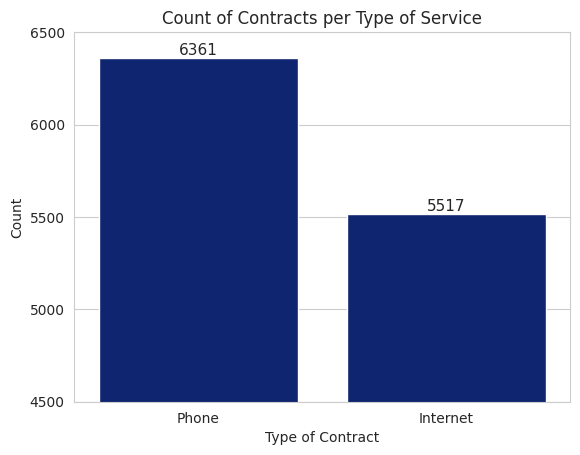

In [62]:
count_users = pd.DataFrame({'User':['Phone', 'Internet'],
                           'Count':[phone_data.shape[0], internet_data.shape[0]]})

ax = sns.barplot(data=count_users, x='User', y='Count')


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11)

ax.set_yticks(range(4500, 6501, 500))
plt.ylim(4500, 6500)
plt.xlabel('Type of Contract')
plt.title('Count of Contracts per Type of Service')

New contracts per year.

Text(0.5, 1.0, 'New Contracts per Year')

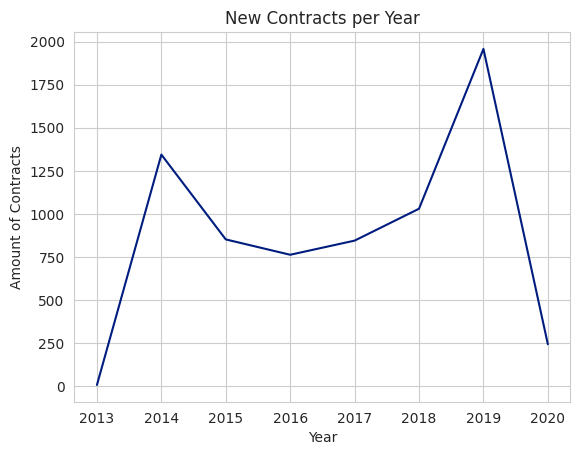

In [63]:
new_contracts_py = contract_data.groupby(contract_data['BeginDate'].dt.year).size()

sns.lineplot(data=new_contracts_py)
plt.xlabel('Year')
plt.ylabel('Amount of Contracts')
plt.title('New Contracts per Year')

Looks like the amount of new users peaked on 2019. On 2020, the info is limited, so its count could be misleading.

Text(0.5, 1.0, 'Users per Gender')

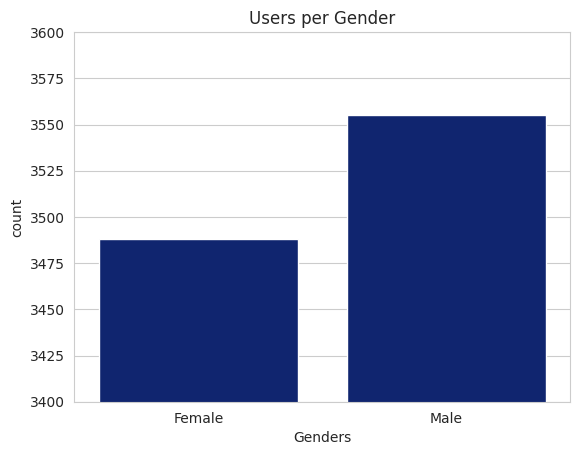

In [64]:
sns.countplot(data=personal_data, x='gender')
plt.ylim(3400,3600)
plt.xlabel('Genders')
plt.title('Users per Gender')

There's not much difference in the amount of male vs female users, only about 100 more male.

Text(0.5, 0, 'MonthlyCharges')

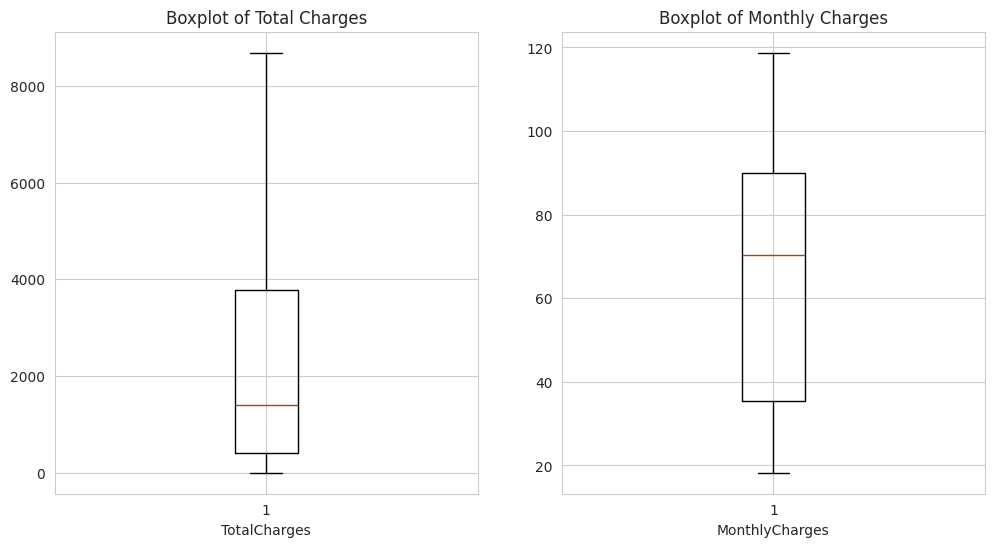

In [65]:
# We'll check on the distribution of charges to identify patterns.

fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].boxplot(contract_data['TotalCharges'])
axs[0].set_title('Boxplot of Total Charges')
axs[0].set_xlabel('TotalCharges')

axs[1].boxplot(contract_data['MonthlyCharges'])
axs[1].set_title('Boxplot of Monthly Charges')
axs[1].set_xlabel('MonthlyCharges')

Text(0.5, 1.0, 'Distribution of Monthly Charges by Churn')

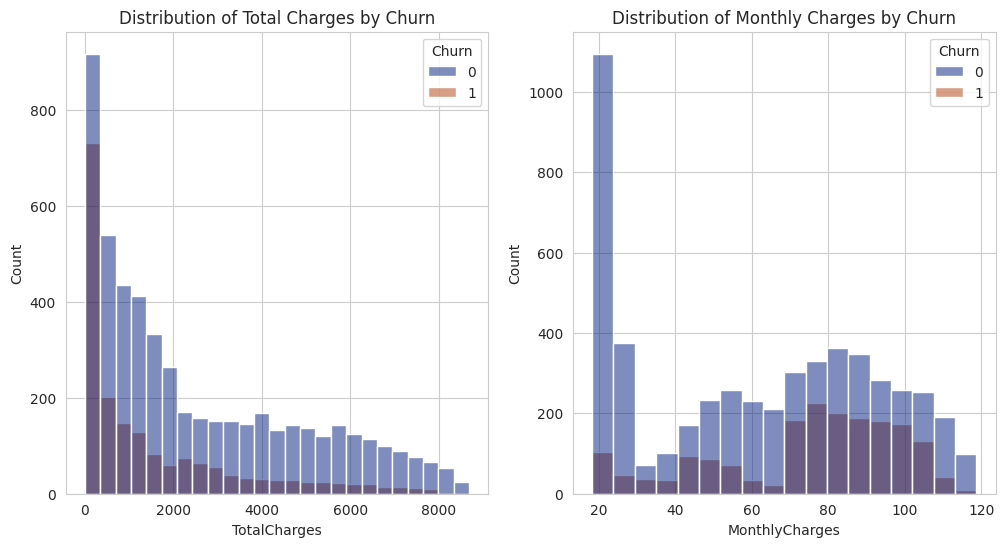

In [66]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

sns.histplot(data=contract_data, x='TotalCharges', hue='Churn', ax=axs[0])
axs[0].set_title('Distribution of Total Charges by Churn')

sns.histplot(data=contract_data, x='MonthlyCharges', hue='Churn', ax=axs[1])
axs[1].set_title('Distribution of Monthly Charges by Churn')

Much of the contracts are new. This is identified by the majority of total charges being on the lower end. Monthly charges are more normally distributed, but most contracts are paying low monthly charges.

Text(0.5, 1.0, 'Churned Contracts per Year')

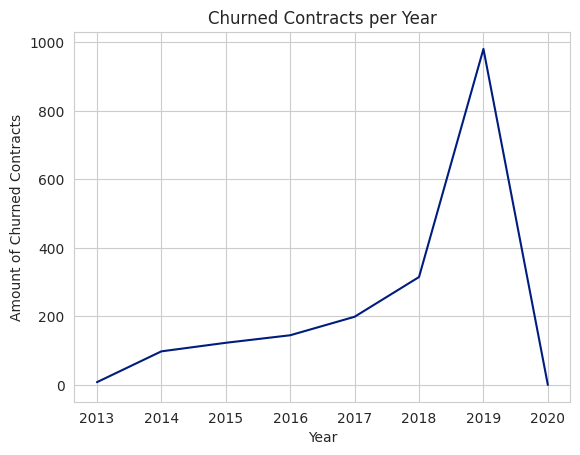

In [67]:
churn_over_time = contract_data.groupby(contract_data['BeginDate'].dt.year).agg({'Churn':'sum'})

sns.lineplot(data=churn_over_time, x=churn_over_time.index, y='Churn')
plt.xlabel('Year')
plt.ylabel('Amount of Churned Contracts')
plt.title('Churned Contracts per Year')

It seems there's been an increase in churned contracts per year, but there's also an increase in new contracts.

Text(0.5, 1.0, 'Total Charges vs Monthly Charges')

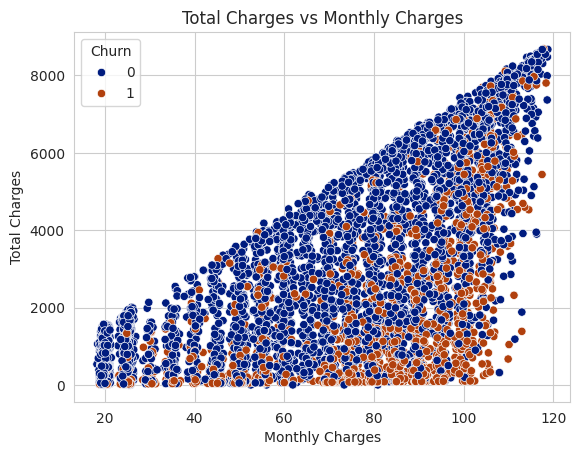

In [68]:
sns.scatterplot(data=contract_data, y='TotalCharges', x='MonthlyCharges', hue='Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.title('Total Charges vs Monthly Charges')

This scatterplot confirms that unchurned contracts tend to have higher total charges, i.e. they're older accounts. Churned contracts tend to be on the lower right corner, high monthly charges but low total charges i.e. newer accounts. One could say that this is then an issue of user retention over time. There are a lot of new accounts, but they tend to churn before increasing the total charges.

,TotalCharges,MonthlyCharges
BeginDate,,
2013,7138.381250,100.531250
2014,5209.432217,76.133743
2015,3910.523181,70.933744
2016,2878.855570,66.808781
2017,2022.987870,66.410888
2018,1130.061019,62.024854
2019,299.965151,57.376980
2020,36.200000,38.067213


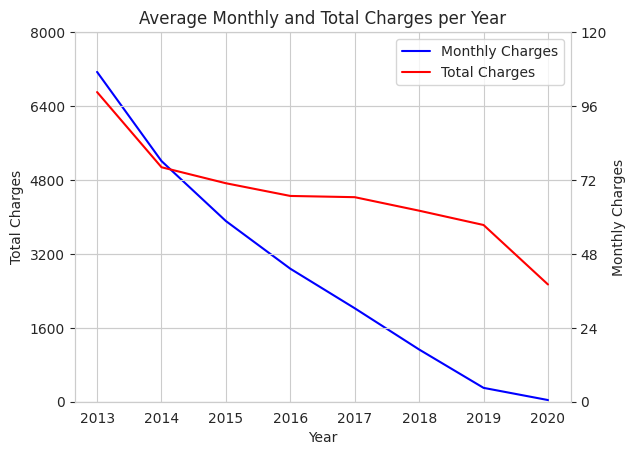

In [69]:
charges_per_year = contract_data.groupby(contract_data['BeginDate'].dt.year).agg({'TotalCharges':'mean', 'MonthlyCharges':'mean'})

fig, ax1 = plt.subplots()

sns.lineplot(data=charges_per_year, x=charges_per_year.index, y='TotalCharges', ax=ax1, label='Monthly Charges', color = 'blue', legend=False)

ax2 = ax1.twinx()
sns.lineplot(data=charges_per_year, x=charges_per_year.index, y='MonthlyCharges', ax=ax2, label = 'Total Charges', color = 'red', legend=False)

ax1.set_xlabel('Year')
ax1.set_ylabel('Total Charges')
ax2.set_ylabel('Monthly Charges')

ax1.set_yticks(range(0,8001,1600))
ax2.set_yticks(range(0,121,24))

ax1.set_ylim(0,8000)
ax2.set_ylim(0,120)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

all_lines = lines_1 + lines_2
all_labels = labels_1 + labels_2

ax1.legend(all_lines, all_labels, loc='upper right')

plt.title('Average Monthly and Total Charges per Year')

display(charges_per_year)

Both the monthly and the total charges are decreasing. This info, mixed with the churned and new contracts per year gives us a more complete view of the status of the company. More contracts are being churned than ever before, most accounts are new with high monthly charges, but they churn rapidly. The company is not being able to keep clients for long. Also, the average monthly spending is decreasing.

Keep in consideration that TotalCharges is expected to drop, because it is cumulative.

In [70]:
print('Descriptive Stats of MonthlyCharges:\n',contract_data['MonthlyCharges'].describe())
print('\nDescriptive Stats of TotalCharges:\n',contract_data['TotalCharges'].describe())

Descriptive Stats of MonthlyCharges:
 count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Descriptive Stats of TotalCharges:
 count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


In [71]:
print(contract_data['Churn'].value_counts(normalize=True)*100)

Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


Approximately 73% of the data consists of examples of contracts that were not terminated (0), and the remaining 27% are those that were terminated (1). Because of this, we will perform an oversampling exercise to train our model with better-balanced data. We will compare the model's performance using metrics such as F1 score and area under the curve (AUC), and we will also compare models that can handle imbalance, such as XGBoost.

It seems that there are no outliers identified in the columns for total or monthly charges according to the boxplots. Total charges are heavily skewed to the left, with half of the data falling between 0 and 1394, and the rest ranging from 1394 to 8684. This could indicate that only a few customers have 'old' accounts, since the total charges column represents the sum of all payments made during the contract, and the more time has passed, the more money has been generated from that contract. Of course, this is also affected by the services they have subscribed to. For example, someone who started their contract in January 2020 will have their total charge equal to their monthly charge, since the data cutoff is February 2020.

Monthly charges appear to be more evenly distributed around the median. Similarly, no outliers were found.

## Action Plan

An imbalance in the target column 'Churn' has been identified. In the following parts of the project, we will explore how to tackle this using oversampling. We could also adjust hyperparameters within the models themselves, such as in Random Forest, where we can adjust the weights using class_weight='balanced' or SMOTE.

Through feature engineering, we will work to create a master dataframe with the features that interest us the most, such as personal data, contract type, payment methods, etc. To achieve this, we will perform a series of joins between the dataframes to consolidate everything into one and be able to generate our predictive model. Once we have our master table, we can start discarding columns that are not useful to us or calculate new ones, such as 'Churn', which indicates whether the contract was terminated or not. This column would be our target function in the model. Different types of binary classification modeling will be tested to try to achieve an adequate F1 score using techniques like one-hot encoding and boosting.

## Feature Selection and Feature Engineering



### Table Merging
We'll left join all tables on CustomerID to have a better look at the data.

In [72]:
df_merged = contract_data.merge(personal_data, on='customerID', how='left')

In [73]:
df_merged = df_merged.merge(internet_data, on='customerID',how='left')

In [74]:
df_merged = df_merged.merge(phone_data, on='customerID',how='left')

In [75]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   int64         
 12  Dependents        7043 non-null   int64         
 13  InternetService   5517 non-null   category      
 14  OnlineSecurity    5517 n

We have merged all the tables into one. We now have 21 columns, from which we will select the most relevant ones to predict our target variable, 'Churn'. A left join was performed to include all customers, even those who do not have internet services or a phone line, which can be identified by the null values. Out of the 7,043 contracts, approximately 4,000 were identified as having both services. The good news is that all customers have their personal information available. We will handle the null values in the next section.

In [76]:
df_merged['InternetService'] = df_merged['InternetService'].cat.add_categories(['No Service'])
df_merged['InternetService'] = df_merged['InternetService'].fillna('No Service')

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   int64         
 12  Dependents        7043 non-null   int64         
 13  InternetService   7043 non-null   category      
 14  OnlineSecurity    5517 n

In [77]:
# Where 0 represents not having the services related to internet service. All
# rows with "No Service" on InternetService should have 0s in these columns

columns = df_merged.columns[14:20]

for column in columns:
    df_merged[column] = df_merged[column].fillna(0).astype('int')

# If 'multiplelines' is null, that means they don't have PhoneService. If they
# otherwise have a record (1 or 0) then they do have PhoneService.

df_merged['PhoneService'] = np.where(df_merged['MultipleLines'].isna(),0,1)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   int64         
 12  Dependents        7043 non-null   int64         
 13  InternetService   7043 non-null   category      
 14  OnlineSecurity    7043 n

In [78]:
# Now that we used that info on nulls, we'll fill them up with 0.

df_merged['MultipleLines'] = df_merged['MultipleLines'].fillna(0).astype('int')

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   int64         
 12  Dependents        7043 non-null   int64         
 13  InternetService   7043 non-null   category      
 14  OnlineSecurity    7043 n

In [94]:
df_merged['ContractAge'] = df_merged['EndDate'] - df_merged['BeginDate']
df_merged['ContractAge'] = df_merged['ContractAge'].dt.days

last_date = pd.to_datetime('2020-02-01 00:00:00')
df_merged['ContractAge'] = np.where(df_merged['ContractAge'].isna(), (last_date - df_merged['BeginDate']).dt.days, df_merged['ContractAge'])

### Visualization

Now that we have a consolidated dataframe we can do some more plotting to get insights.

Text(0.5, 1.0, 'Contract Age Distribution')

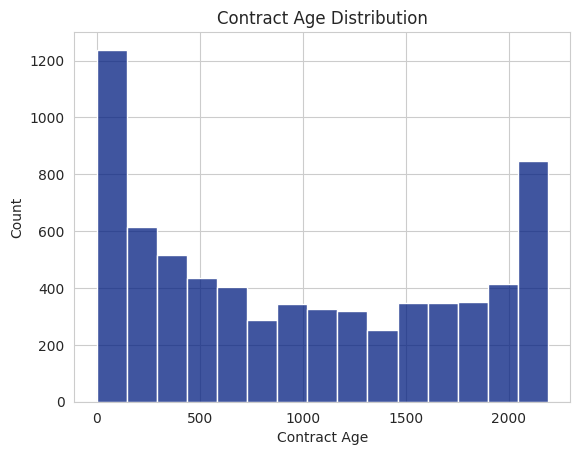

In [95]:
sns.histplot(data=df_merged, x='ContractAge')
plt.xlabel('Contract Age')
plt.title('Contract Age Distribution')

SeniorCitizen  Churn
0              0        76.0
               1        24.0
1              0        58.0
               1        42.0
Name: proportion, dtype: float64
SeniorCitizen  PaperlessBilling
0              1                   56.0
               0                   44.0
1              1                   77.0
               0                   23.0
Name: proportion, dtype: float64


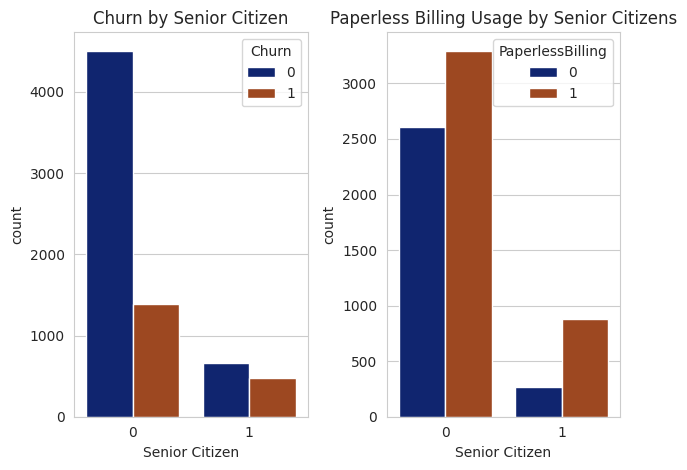

In [139]:
fig,axs = plt.subplots(1,2)

sns.countplot(data=df_merged, x='SeniorCitizen', hue='Churn', ax=axs[0])
axs[0].set_title('Churn by Senior Citizen')
axs[0].set_xlabel('Senior Citizen')

sns.countplot(data=df_merged, x='SeniorCitizen', hue='PaperlessBilling', ax=axs[1])
axs[1].set_title('Paperless Billing Usage by Senior Citizens')
axs[1].set_xlabel('Senior Citizen')


print(round(df_merged.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True)*100, 0))
print(round(df_merged.groupby('SeniorCitizen')['PaperlessBilling'].value_counts(normalize=True)*100, 0))

plt.tight_layout()

There's a much higher relative ratio of churned to un-churned contracts when the citizen is a senior. 24% of non senior citizens churned. On the other hand, 42% of seniors churned. What's there that is causing seniors to churn?

One would think that seniors would be using paperless less often that non seniors but that doesn't appear to be the case, they're using it even more within their group.

gender  Churn
Female  0        73.0
        1        27.0
Male    0        74.0
        1        26.0
Name: proportion, dtype: float64


/tmp/ipython-input-144-2528653702.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(round(df_merged.groupby('gender')['Churn'].value_counts(normalize=True)*100, 0))


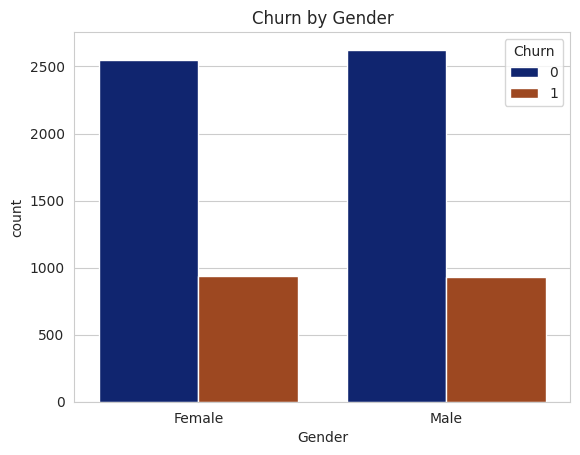

In [144]:
sns.countplot(data=df_merged, x='gender', hue='Churn')
plt.xlabel('Gender')
plt.title('Churn by Gender')

print(round(df_merged.groupby('gender')['Churn'].value_counts(normalize=True)*100, 0))

This is not the case for female vs male churns, as their ratio of churn to not-churn is largely the same.

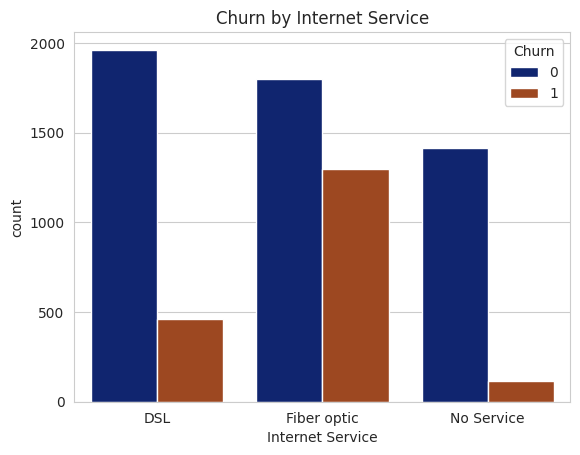

In [143]:
ax=sns.countplot(data=df_merged, x='InternetService', hue='Churn')
plt.xlabel('Internet Service')
plt.title('Churn by Internet Service')
ax.set_yticks(range(0,2001,500))

Seems like most of the churned contracts come from optic fibre internet services. Contracts with no internet service at all seem to be "happier". Perhaps there's an issue with the optic fiber service?

### Feature Selection

With this, we now have our database consolidated and clean. We are going to remove the columns that are not relevant for predicting whether a customer will terminate their contract or not. We will a priori choose the columns that are not expected to be relevant, such as gender, customerID, begindate, and enddate.

In [142]:
df_merged_filtered = df_merged.drop(['customerID','BeginDate','EndDate','gender'],axis=1)

#### One Hot Encoding

In [44]:
#Ya que estamos manejando un objetivo categórico, no hay riesgo de multicolinearidad

categorical_columns = ['Type','PaymentMethod','InternetService']

df_encoded = pd.get_dummies(df_merged_filtered,columns=categorical_columns)

display(df_encoded.head())

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No Service
0,1,29.85,29.85,0,0,1,0,0,1,0,...,True,False,False,False,False,True,False,True,False,False
1,0,56.95,1889.50,0,0,0,0,1,0,1,...,False,True,False,False,False,False,True,True,False,False
2,1,53.85,108.15,1,0,0,0,1,1,0,...,True,False,False,False,False,False,True,True,False,False
3,0,42.30,1840.75,0,0,0,0,1,0,1,...,False,True,False,True,False,False,False,True,False,False
4,1,70.70,151.65,1,0,0,0,0,0,0,...,True,False,False,False,False,True,False,False,True,False


### Correlation with Churn
We will use the correlation of the columns with Churn to select the most important ones. These will be defined as those with an absolute value greater than 0.1. We're also using the RanfomForestClassifier importances method to see if these selected features match.

In [45]:
correlation = df_encoded.corr()['Churn'].sort_values(ascending=False)
print(correlation)

Churn                                      1.000000
Type_Month-to-month                        0.405103
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
StreamingTV                                0.063228
StreamingMovies                            0.061382
MultipleLines                              0.040102
PhoneService                               0.011942
DeviceProtection                          -0.066160
OnlineBackup                              -0.082255
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
InternetService_DSL                       -0.124214
PaymentMethod_Credit card (automatic)     -0.134302
Partner                                   -0.150448
Dependents                                -0.164221
TechSupport 

In [46]:
high_corr_columns = []

for column in correlation.index:
    if abs(correlation[column]) > 0.1:
        high_corr_columns.append(column)

df_encoded_filtered = df_encoded[high_corr_columns]
print(df_encoded_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Churn                                    7043 non-null   int64  
 1   Type_Month-to-month                      7043 non-null   bool   
 2   InternetService_Fiber optic              7043 non-null   bool   
 3   PaymentMethod_Electronic check           7043 non-null   bool   
 4   MonthlyCharges                           7043 non-null   float64
 5   PaperlessBilling                         7043 non-null   int64  
 6   SeniorCitizen                            7043 non-null   int64  
 7   PaymentMethod_Bank transfer (automatic)  7043 non-null   bool   
 8   InternetService_DSL                      7043 non-null   bool   
 9   PaymentMethod_Credit card (automatic)    7043 non-null   bool   
 10  Partner                                  7043 no

In [47]:
model = RandomForestClassifier(random_state=12345)
model.fit(df_encoded.drop('Churn',axis=1),df_encoded['Churn'])

importances = pd.Series(model.feature_importances_, index=df_encoded.drop('Churn',axis=1).columns)
importances.sort_values(ascending=False)

selected_features = importances[importances > 0.02].index

df_encoded_filtered_RFC = df_encoded[selected_features]
df_encoded_filtered_RFC['Churn'] = df_encoded['Churn']

print(df_encoded_filtered_RFC.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PaperlessBilling                7043 non-null   int64  
 1   MonthlyCharges                  7043 non-null   float64
 2   TotalCharges                    7043 non-null   float64
 3   SeniorCitizen                   7043 non-null   int64  
 4   Partner                         7043 non-null   int64  
 5   Dependents                      7043 non-null   int64  
 6   OnlineSecurity                  7043 non-null   int64  
 7   OnlineBackup                    7043 non-null   int64  
 8   DeviceProtection                7043 non-null   int64  
 9   TechSupport                     7043 non-null   int64  
 10  StreamingMovies                 7043 non-null   int64  
 11  MultipleLines                   7043 non-null   int64  
 12  Type_Month-to-month             70

/tmp/ipython-input-47-2662354165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_filtered_RFC['Churn'] = df_encoded['Churn']


#### Class Balancing

We are going to increase the number of rows where churn is 1 to approximate a 50:50 ratio. We will use SMOTE to rebalance the classes with random oversampling.

In [48]:
pip install --user imbalanced-learn

In [49]:
from imblearn.over_sampling import SMOTE

features = df_encoded_filtered.drop('Churn',axis=1)
target = df_encoded_filtered['Churn']

smote = SMOTE(random_state=12345)
features_resampled, target_resampled = smote.fit_resample(features,target)

df_resampled = pd.DataFrame(features_resampled, columns=features.columns)
df_resampled['Churn'] = target_resampled

print(df_resampled['Churn'].value_counts())

Churn
0    5174
1    5174
Name: count, dtype: int64


#### Scaling MonthlyCharges and TotalCharges

We are going to scale the continuous data for monthly and total charges to bring them closer to 1 and 0, in order to prevent the model from giving them too much weight.

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_resampled[['MonthlyCharges','TotalCharges']] = scaler.fit_transform(df_resampled[['MonthlyCharges','TotalCharges']])

df_resampled.head()

,Type_Month-to-month,InternetService_Fiber optic,PaymentMethod_Electronic check,MonthlyCharges,PaperlessBilling,SeniorCitizen,PaymentMethod_Bank transfer (automatic),InternetService_DSL,PaymentMethod_Credit card (automatic),Partner,Dependents,TechSupport,OnlineSecurity,Type_One year,TotalCharges,InternetService_No Service,Type_Two year,Churn
0,True,False,True,-1.326002,1,0,False,True,False,1,0,0,0,False,-0.922351,False,False,0
1,False,False,False,-0.379446,0,0,False,True,False,0,0,0,1,True,-0.067506,False,False,0
2,True,False,False,-0.487724,1,0,False,True,False,0,0,0,1,False,-0.886358,False,False,1
3,False,False,False,-0.891145,0,0,True,True,False,0,0,1,1,True,-0.089916,False,False,0
4,True,True,True,0.100818,1,0,False,False,False,0,0,0,0,False,-0.866362,False,False,1


## Modeling

With our classes balanced, features one-hot encoded, filtered by correlation greater than 0.1, and continuous features scaled, we can start modeling and evaluating predictions, and then proceed to modify and improve.

### Training and Validation Data Split

We will split 80% of the dataframe for training and 20% for validation.

In [51]:
features = df_resampled.drop('Churn',axis=1)
target = df_resampled['Churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

### RandomForestClassifier

In [52]:
model = RandomForestClassifier(random_state=12345)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(features_train, target_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [55]:
target_predict = best_model.predict(features_test)

print('Mejores parámetros:',best_params)
print(classification_report(target_test, target_predict))
target_probs = best_model.predict_proba(features_test)[:, 1]

Mejores parámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1007
           1       0.83      0.86      0.85      1063

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



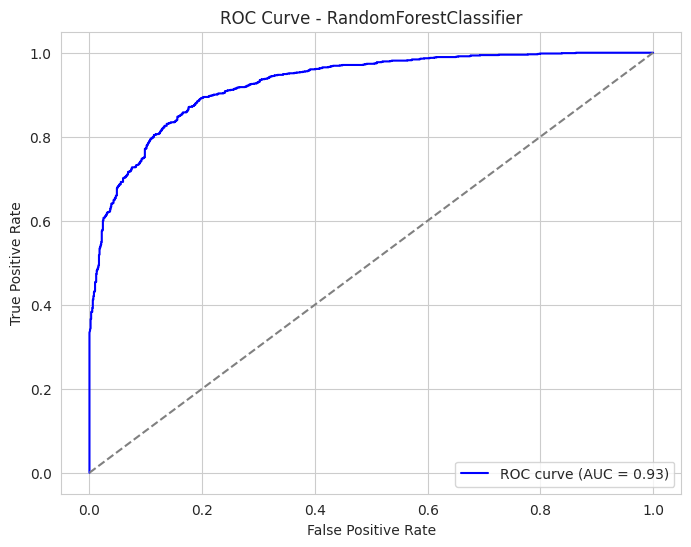

In [165]:
fpr, tpr, _ = roc_curve(target_test, target_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

### LogisticRegressor

In [57]:
model_lr = LogisticRegression(solver='liblinear',random_state=12345, max_iter = 10000)

model_lr.fit(features_train, target_train)

target_predict_lr = model_lr.predict(features_test)

In [58]:
print(classification_report(target_test,target_predict_lr))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1007
           1       0.81      0.85      0.83      1063

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



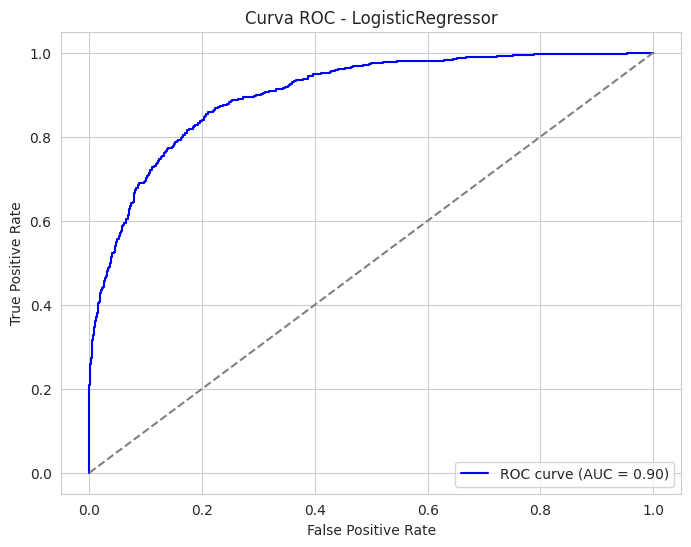

In [166]:
target_probs = model_lr.predict_proba(features_test)[:, 1]
fpr, tpr, _ = roc_curve(target_test, target_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LogisticRegressor')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [60]:
model_xgb = XGBClassifier()
model_xgb.fit(features_train, target_train)
target_predict_xgb = model_xgb.predict(features_test)

In [61]:
print(classification_report(target_test,target_predict_xgb))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1007
           1       0.85      0.84      0.85      1063

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



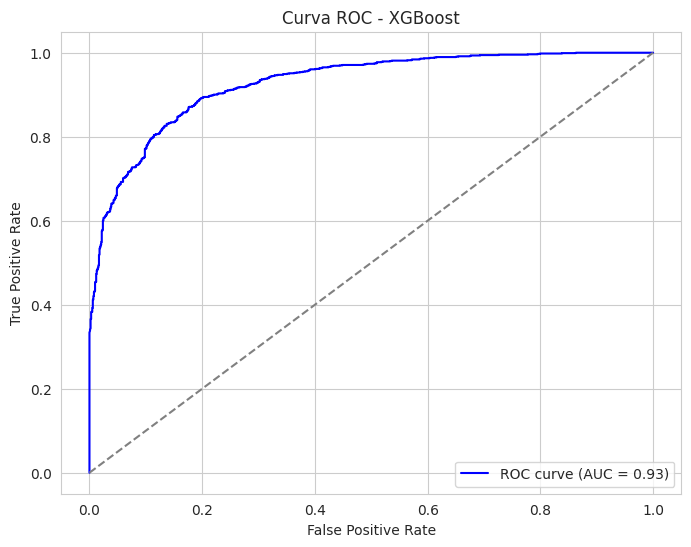

In [99]:
target_probs = model_xgb.predict_proba(features_test)[:, 1]
fpr, tpr, _ = roc_curve(target_test, target_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend(loc="lower right")
plt.show()

## Conclusions

In this project, a predictive model was developed with the goal of identifying Interconnect customers who are most likely to cancel their contracts. To achieve this, a structured process was followed, which included several key stages.

First, four datasets containing relevant information were imported: personal data, internet usage, contract details, and phone records. A thorough data cleaning process was then carried out, filling in missing values, checking for inconsistencies, and generating the target variable "churn."

Once the data was cleaned, exploratory analysis was conducted to better understand customer behavior. Charts and descriptive statistics were used to detect patterns and trends. The four dataframes were then merged into a single consolidated dataset, allowing for correlation analysis between variables to determine which were most related to service cancellation.

Since the "churn" variable showed class imbalance, techniques were applied to balance the proportion of customers who canceled vs. those who did not, aiming for a more equitable 50:50 distribution. Additionally, categorical variables were transformed using one-hot encoding, and non-binary variables were scaled to ensure all features were in a suitable format for training.

Three classification models were tested: XGBoost, Random Forest, and Logistic Regression. Among them, XGBoost showed the best performance, achieving an F1 score of 0.84, making it the most accurate model for predicting customers likely to churn.

Thanks to this model, Interconnect now has a powerful tool to anticipate customer loss, enabling the implementation of more effective retention strategies and improving the overall user experience.


## Solution Report

### Which steps of the plan were completed and which were omitted?

The following actions were carried out during the development of the project:

- **Phase 1:** Verification of duplicates, missing values, and data types, followed by initial visualizations to understand the data distribution.  
- **Phase 2:** Variable conversion, creation of the "Churn" column, and review of class balance.  
- **Phase 3:** Correlation analysis to identify relationships between variables. Low-value columns were removed based on the results, and the four datasets were merged.  
- **Phase 4:** Transformation using One-Hot Encoding, data scaling, and class balancing with SMOTE.  
- **Phase 5:** Modeling using XGBoost, Logistic Regression, and RandomForestClassifier. Model evaluation with key metrics: F1, Recall, Accuracy, and ROC AUC curves.  
- **Phase 6:** Development of recommendations and final comments on model performance.

No specific step was omitted.

### What difficulties did you encounter and how did you resolve them?

There was a bit of a challenge with class imbalance, as around 25% of the values in the "Churn" column were 1 and 75% were 0. This was resolved using SMOTE to generate synthetic entries for the minority class, ensuring that our models were not negatively affected. Additionally, total and monthly charges were scaled to prevent them from having too much influence on the model weights.

### What were some of the key steps in solving the task?

One of the most critical steps was generating the "Churn" column, which served as our target variable. This column was not initially included in the datasets, so creating it was essential to give our models something to predict. Another key step was merging all the datasets into a single, unified dataframe, allowing us to work with a complete set of features.

While data cleaning and class balancing were also important, none of it would have been possible without first defining a clear target variable. Without it, there would have been no model to train in the first place.

### What is your final model and what is its performance level?

The final model selected is **XGBoost**, as it delivered the best results across key metrics: an F1 score of **0.84**, high precision and recall, and an **AUC-ROC score of 0.92**.

XGBoost stands out not only for its strong predictive performance but also for its efficiency and robustness. It handles missing values automatically, supports both L1 and L2 regularization to reduce overfitting, and is optimized for speed and scalability. These qualities make it a highly suitable choice for production-level deployment in churn prediction tasks.